# T5 training test

In [1]:
from transformers import AutoTokenizer, DataCollatorWithPadding, TrainingArguments, Trainer, EvalPrediction, T5ForConditionalGeneration
import pandas as pd
import numpy as np
from datasets import Dataset, DatasetDict, load_from_disk, concatenate_datasets
import torch
from sklearn.metrics import accuracy_score, classification_report, f1_score
from typing import Dict
import wandb

## Create dataset GUG

In [3]:
data = pd.read_csv("/home/mlynatom/data/gug/gug_annotations.tsv", sep="\t")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Id                       3129 non-null   int64  
 1   Sentence                 3129 non-null   object 
 2   Expert Judgement         3129 non-null   int64  
 3   Crowd Flower Judgements  3129 non-null   object 
 4   Average                  3129 non-null   float64
 5   Dataset                  3129 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 146.8+ KB


In [5]:
data = data[data["Expert Judgement"] != 0]

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3019 entries, 0 to 3128
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Id                       3019 non-null   int64  
 1   Sentence                 3019 non-null   object 
 2   Expert Judgement         3019 non-null   int64  
 3   Crowd Flower Judgements  3019 non-null   object 
 4   Average                  3019 non-null   float64
 5   Dataset                  3019 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 165.1+ KB


In [18]:
#data["Expert Judgement"] = data["Expert Judgement"] -1

In [7]:
transl_dict = {
    1:"Incomprehensible",
    2:"Somewhat Comprehensible",
    3:"Comprehensible",
    4:"Perfect"
}

data["Expert Judgement"] = data["Expert Judgement"].apply(lambda x: transl_dict[x])

In [8]:
data.Dataset.unique()

array(['train', 'test', 'dev'], dtype=object)

In [9]:
data["Expert Judgement"].unique()

array(['Comprehensible', 'Somewhat Comprehensible', 'Incomprehensible',
       'Perfect'], dtype=object)

In [10]:
train = data[data["Dataset"] == 'train']
dev = data[data["Dataset"] == 'dev']
test =data[data["Dataset"] == 'test']

In [11]:
display(train.info())
display(dev.info())
display(test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1518 entries, 0 to 3127
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Id                       1518 non-null   int64  
 1   Sentence                 1518 non-null   object 
 2   Expert Judgement         1518 non-null   object 
 3   Crowd Flower Judgements  1518 non-null   object 
 4   Average                  1518 non-null   float64
 5   Dataset                  1518 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 83.0+ KB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 747 entries, 2 to 3126
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Id                       747 non-null    int64  
 1   Sentence                 747 non-null    object 
 2   Expert Judgement         747 non-null    object 
 3   Crowd Flower Judgements  747 non-null    object 
 4   Average                  747 non-null    float64
 5   Dataset                  747 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 40.9+ KB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 754 entries, 1 to 3128
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Id                       754 non-null    int64  
 1   Sentence                 754 non-null    object 
 2   Expert Judgement         754 non-null    object 
 3   Crowd Flower Judgements  754 non-null    object 
 4   Average                  754 non-null    float64
 5   Dataset                  754 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 41.2+ KB


None

In [12]:
train_hf = Dataset.from_pandas(train)
dev_hf = Dataset.from_pandas(dev)
test_hf = Dataset.from_pandas(test)

In [13]:
dataset = DatasetDict()
dataset["train"] = train_hf
dataset["validation"] = dev_hf
dataset["test"] = test_hf

In [14]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Id', 'Sentence', 'Expert Judgement', 'Crowd Flower Judgements', 'Average', 'Dataset', '__index_level_0__'],
        num_rows: 1518
    })
    validation: Dataset({
        features: ['Id', 'Sentence', 'Expert Judgement', 'Crowd Flower Judgements', 'Average', 'Dataset', '__index_level_0__'],
        num_rows: 747
    })
    test: Dataset({
        features: ['Id', 'Sentence', 'Expert Judgement', 'Crowd Flower Judgements', 'Average', 'Dataset', '__index_level_0__'],
        num_rows: 754
    })
})

In [15]:
dataset = dataset.remove_columns(['Crowd Flower Judgements', 'Average', 'Dataset', '__index_level_0__'])

In [16]:
dataset = dataset.rename_column("Expert Judgement", "label")
dataset = dataset.rename_column("Sentence", "sentence")
dataset

DatasetDict({
    train: Dataset({
        features: ['Id', 'sentence', 'label'],
        num_rows: 1518
    })
    validation: Dataset({
        features: ['Id', 'sentence', 'label'],
        num_rows: 747
    })
    test: Dataset({
        features: ['Id', 'sentence', 'label'],
        num_rows: 754
    })
})

In [17]:
dataset.save_to_disk("/home/mlynatom/data/gug/gug_hf")

Saving the dataset (0/1 shards):   0%|          | 0/1518 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/747 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/754 [00:00<?, ? examples/s]

## Create Dataset FCE

fce_v2.1.bea19

In [127]:
train = pd.read_json("/home/mlynatom/data/fce/fce.train.json", lines=True)
dev = pd.read_json("/home/mlynatom/data/fce/fce.dev.json", lines=True)
test = pd.read_json("/home/mlynatom/data/fce/fce.test.json", lines=True)

In [128]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2116 entries, 0 to 2115
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      2116 non-null   object
 1   age       2104 non-null   object
 2   q         2116 non-null   object
 3   script-s  2116 non-null   int64 
 4   edits     2116 non-null   object
 5   l1        2116 non-null   object
 6   id        2116 non-null   object
 7   answer-s  2114 non-null   object
dtypes: int64(1), object(7)
memory usage: 132.4+ KB


In [129]:
train

,text,age,q,script-s,edits,l1,id,answer-s
0,"Dear Sir or Madam,\n\nI am writing in order to...",21-25,1,31,"[[0, [[71, 76, 'with', 'RT'], [118, 122, 'saw'...",ca,TR1*0102*2000*01,4.3
1,"Unfortunately, Pat wasn't very good at keeping...",21-25,2,31,"[[0, [[233, 233, ',', 'MP'], [249, 249, '""', '...",ca,TR1*0102*2000*01,5.1
2,"10 June 2000\n\nDear Manager,\n\nI would like ...",26-30,1,29,"[[0, [[238, 238, 'in', 'MT'], [473, 473, 'the'...",ko,TR2*0102*2000*01,3.3
3,Fashion of the future\n\nPeople will wear this...,26-30,3,29,"[[0, [[71, 76, '', 'UJ'], [91, 91, 'the', 'MD'...",ko,TR2*0102*2000*01,3.3
4,DECEMBER 12TH\n\nPRINCIPAL MR. ROBERTSON\n\nDE...,16-20,1,28,"[[0, [[61, 65, 'THANK', 'S'], [142, 144, 'ON',...",ca,TR3*0100*2000*02,2.3
...,...,...,...,...,...,...,...,...
2111,If you ask at twenty womans what is their favo...,16-20,3,29,"[[0, [[11, 13, '', 'UT'], [21, 27, 'women', 'I...",it,TR1138*0100*2000*01,3.3
2112,Dear Mr. Smith;\n\nI am writing this letter to...,0-16,1,24,"[[0, [[14, 15, ',', 'RP'], [45, 49, 'let', 'RV...",tr,TR1139*0102*2000*01,3.1
2113,TECHNOLOGICAL ADVANTAGES\n\nTechnology is the ...,0-16,4,24,"[[0, [[242, 243, '', 'UD'], [300, 305, 'work',...",tr,TR1139*0102*2000*01,3.2
2114,"Dear Sir or Madam,\n\nI am writing to express ...",21-25,1,34,"[[0, [[63, 68, 'with', 'RT'], [82, 91, 'put on...",it,TR1140*0102*2000*01,4.3


In [130]:
display(train["answer-s"].value_counts())
display(dev["answer-s"].value_counts())
display(test["answer-s"].value_counts())

3.3     293
3.2     280
3.1     256
4.1     223
4.2     190
4.3     176
5.1     152
2.3     150
2.3T    103
2.2      89
5.2      71
5.3      41
2.1      37
1.3      28
1.2       9
0         5
S         3
1.1       3
2.        1
.1        1
5/1       1
1         1
.2        1
Name: answer-s, dtype: int64

3.3     26
4.1     20
3.2     20
3.1     15
4.3     13
4.2     12
2.3T    10
5.1     10
2.3      8
2.2      8
5.2      5
2.1      4
1.2      2
5.3      2
S        2
.2       1
1.3      1
Name: answer-s, dtype: int64

3.2     25
3.1     24
3.3     23
5.1     20
2.3T    19
4.1     16
5.2     14
2.2     11
2.3      9
2.1      9
4.3      8
5.3      6
4.2      5
1.3      3
1.2      2
Name: answer-s, dtype: int64

In [131]:
def process_df(data_train):
    data_train.dropna(inplace=True)
    data_train = data_train[data_train["answer-s"] != "S"]
    data_train = data_train[data_train["answer-s"] != "5/1"]
    data_train["answer-s"].replace("2.3T", "2.3", inplace=True)
    data_train["answer-s"] = pd.to_numeric(data_train["answer-s"], downcast="integer")
    data_train["answer-s"] = data_train["answer-s"].astype(int)
    data_train.drop(["age", "q", "script-s", "edits", "l1"], axis=1, inplace=True)
    transl_dict = {
    0: "fce_0",
    1: "fce_1",
    2:"fce_2",
    3:"fce_3",
    4:"fce_4",
    5:"fce_5"
    }

    data_train["answer-s"] = data_train["answer-s"].apply(lambda x: transl_dict[x])

    return data_train
    

In [132]:
train = process_df(train)
dev = process_df(dev)
test = process_df(test)

In [133]:
train

,text,id,answer-s
0,"Dear Sir or Madam,\n\nI am writing in order to...",TR1*0102*2000*01,fce_4
1,"Unfortunately, Pat wasn't very good at keeping...",TR1*0102*2000*01,fce_5
2,"10 June 2000\n\nDear Manager,\n\nI would like ...",TR2*0102*2000*01,fce_3
3,Fashion of the future\n\nPeople will wear this...,TR2*0102*2000*01,fce_3
4,DECEMBER 12TH\n\nPRINCIPAL MR. ROBERTSON\n\nDE...,TR3*0100*2000*02,fce_2
...,...,...,...
2111,If you ask at twenty womans what is their favo...,TR1138*0100*2000*01,fce_3
2112,Dear Mr. Smith;\n\nI am writing this letter to...,TR1139*0102*2000*01,fce_3
2113,TECHNOLOGICAL ADVANTAGES\n\nTechnology is the ...,TR1139*0102*2000*01,fce_3
2114,"Dear Sir or Madam,\n\nI am writing to express ...",TR1140*0102*2000*01,fce_4


In [134]:
train_hf = Dataset.from_pandas(train)
dev_hf = Dataset.from_pandas(dev)
test_hf = Dataset.from_pandas(test)

In [135]:
dataset = DatasetDict()
dataset["train"] = train_hf
dataset["validation"] = dev_hf
dataset["test"] = test_hf

In [136]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'id', 'answer-s', '__index_level_0__'],
        num_rows: 2098
    })
    validation: Dataset({
        features: ['text', 'id', 'answer-s', '__index_level_0__'],
        num_rows: 157
    })
    test: Dataset({
        features: ['text', 'id', 'answer-s', '__index_level_0__'],
        num_rows: 192
    })
})

In [137]:
dataset = dataset.remove_columns(['id'])

In [138]:
dataset = dataset.rename_column("answer-s", "label")

In [139]:
dataset = dataset.rename_column("text", "sentence")

In [140]:
dataset = dataset.rename_column("__index_level_0__", "Id")

In [146]:
dataset = dataset.map(lambda example : {"Id": example["Id"]+100000})

Map:   0%|          | 0/2098 [00:00<?, ? examples/s]

Map:   0%|          | 0/157 [00:00<?, ? examples/s]

Map:   0%|          | 0/192 [00:00<?, ? examples/s]

In [147]:
dataset.save_to_disk("/home/mlynatom/data/fce/fce_hf")

Saving the dataset (0/1 shards):   0%|          | 0/2098 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/157 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/192 [00:00<?, ? examples/s]

## Train

In [2]:
tokenizer = AutoTokenizer.from_pretrained("grammarly/coedit-large")
model = T5ForConditionalGeneration.from_pretrained("grammarly/coedit-large")

In [2]:
tokenizer = AutoTokenizer.from_pretrained("grammarly/coedit-xl")
model = T5ForConditionalGeneration.from_pretrained("grammarly/coedit-xl")

### freeze

In [3]:
model

T5ForSequenceClassification(
  (transformer): T5Model(
    (shared): Embedding(32100, 1024)
    (encoder): T5Stack(
      (embed_tokens): Embedding(32100, 1024)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=1024, out_features=1024, bias=False)
                (k): Linear(in_features=1024, out_features=1024, bias=False)
                (v): Linear(in_features=1024, out_features=1024, bias=False)
                (o): Linear(in_features=1024, out_features=1024, bias=False)
                (relative_attention_bias): Embedding(32, 16)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseGatedActDense(
                (wi_0): Linear(in_features=1024, out_features=2816, bias=False)
                (w

In [4]:
for param in model.parameters():
    param.requires_grad = False


for param in model.classification_head.parameters():
    param.requires_grad = True

In [23]:
for param in model.parameters():
    print(f"{param.requires_grad}")

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


### data

In [3]:
datasets_gug = load_from_disk("/home/mlynatom/data/gug/gug_hf")
datasets_gug["train"][0]

{'Id': 1,
 'sentence': 'If the teacher once entered in to the class she should be well preaperd of what she is going to explain.',
 'label': 'Comprehensible'}

In [4]:
dataset_fce = load_from_disk("/home/mlynatom/data/fce/fce_hf")
dataset_fce["train"][0]

{'sentence': 'Dear Sir or Madam,\n\nI am writing in order to express my disappointment about your musical show "Over the Rainbow".\n\nI saws the show\'s advertisement hanging up of a wall in London where I was spending my holiday with some friends. I convinced them to go there with me because I had heard good references about your Company and, above all, about the main star, Danny Brook.\n\nThe problems started in the box office, where we asked for the discounts you announced in the advertisement, and the man who was selling the tickets said that they didn\'t exist.\n\nMoreover, the show was delayed forty-five minutes and the worst of all was that Danny Brook had been replaced by another actor.\n\nOn the other hand, the theatre restaurant was closed because unknown reasons.\n\nYou promised a perfect evening but it became a big disastrous!\n\nI would like some kind of explanation and receive my money back. If you don\'t agree, I will act consequently.\n\nI look forward to hearing from y

In [5]:
dataset_fce

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'Id'],
        num_rows: 2098
    })
    validation: Dataset({
        features: ['sentence', 'label', 'Id'],
        num_rows: 157
    })
    test: Dataset({
        features: ['sentence', 'label', 'Id'],
        num_rows: 192
    })
})

In [6]:
datasets_train = concatenate_datasets([datasets_gug["train"], dataset_fce["train"]])
datasets_validation = concatenate_datasets([datasets_gug["validation"], dataset_fce["validation"]])
datasets_test = concatenate_datasets([datasets_gug["test"], dataset_fce["test"]])

In [7]:
datasets = DatasetDict()

datasets["train"] = datasets_train
datasets["validation"] = datasets_validation
datasets["test"] = datasets_test

In [20]:
TASK_PREFIX_GUG = "<gug>Rate the grammaticality: "
TASK_PREFIX_FCE = "<fce>Rate the answer: "
def tokenize_function(example):
    model_inputs = tokenizer(
        [TASK_PREFIX_GUG + sentence if s_id < 100000 else TASK_PREFIX_FCE + sentence for sentence, s_id in zip(example["sentence"], example["Id"])],
        max_length = 512,
        truncation = True,
    )
    labels = tokenizer(example["label"], max_length=30, truncation=True)

    labels["input_ids"] = [
                [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
            ]

    model_inputs["labels"] = labels["input_ids"]

    return model_inputs


tokenized_datasets = datasets.map(tokenize_function, remove_columns=["Id", "sentence", "label"], batched=True)

Map:   0%|          | 0/3616 [00:00<?, ? examples/s]

Map:   0%|          | 0/904 [00:00<?, ? examples/s]

Map:   0%|          | 0/946 [00:00<?, ? examples/s]

In [22]:
tokenized_datasets["train"][0]

{'input_ids': [3,
  2,
  1744,
  122,
  3155,
  448,
  342,
  8,
  3,
  5096,
  4992,
  10355,
  10,
  156,
  8,
  3145,
  728,
  5136,
  16,
  12,
  8,
  853,
  255,
  225,
  36,
  168,
  4745,
  883,
  26,
  13,
  125,
  255,
  19,
  352,
  12,
  3209,
  5,
  1],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'labels': [2570, 22459, 2296, 1]}

In [32]:
learning_rate = 5e-5
batch_size = 32
num_epochs = 5
warmup_ratio = 0.2

In [24]:
%env WANDB_PROJECT=t5test

env: WANDB_PROJECT=t5test


In [33]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="models/t5_test_instr_fce_gug_xl",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.03,
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_steps=100,
    save_steps=100,
    fp16=False,
    report_to=["wandb"],
    warmup_ratio=warmup_ratio,
    overwrite_output_dir=True,
    predict_with_generate=True,
    gradient_accumulation_steps=1,
    gradient_checkpointing=True,
    tf32=True,
    bf16=True,
    #torch_compile=True,
)

In [34]:
def compute_metrics(pred) -> Dict:
    logits, labels = pred
    preds = np.argmax(logits, axis=1)
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    return {
        "accuracy": accuracy,
        "f1": f1
        }

In [35]:
from transformers import DataCollatorForSeq2Seq, Seq2SeqTrainer

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, label_pad_token_id=-100)

In [36]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    #compute_metrics=compute_metrics,
)

trainer.train()

Step,Training Loss,Validation Loss
100,No log,0.322402
200,No log,0.268766
300,No log,0.247980
400,No log,0.279691
500,0.316800,0.278069


TrainOutput(global_step=565, training_loss=0.3008184500500164, metrics={'train_runtime': 659.5108, 'train_samples_per_second': 27.414, 'train_steps_per_second': 0.857, 'total_flos': 3.0433153646985216e+16, 'train_loss': 0.3008184500500164, 'epoch': 5.0})

In [37]:
trainer.evaluate()

{'eval_loss': 0.2638375759124756,
 'eval_runtime': 2.7192,
 'eval_samples_per_second': 332.449,
 'eval_steps_per_second': 10.665,
 'epoch': 5.0}

In [38]:
model.save_pretrained("/home/mlynatom/models/coedit_L_gug_fce_instr")

In [22]:
model = T5ForConditionalGeneration.from_pretrained("/home/mlynatom/models/coedit_gug/")

In [39]:
print(torch.cuda.get_device_name(0))

NVIDIA A100-SXM4-40GB


### gug

In [14]:
from transformers import pipeline
pipe = pipeline("text2text-generation", model="/home/mlynatom/models/coedit_gug/", tokenizer="grammarly/coedit-large", framework="pt", device=0, batch_size = 128)

In [15]:
res = pipe(datasets["test"]["sentence"])

/home/mlynatom/venvs/py3.10.4/lib/python3.10/site-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [16]:
res = [x["generated_text"] for x in res]

In [17]:
df = pd.DataFrame(list(zip(res, datasets["test"]["label"])), columns=["result", "test"])

In [18]:
df

,result,test
0,Comprehensible,Somewhat Comprehensible
1,Comprehensible,Incomprehensible
2,Perfect,Comprehensible
3,Perfect,Perfect
4,Somewhat Comprehensible,Somewhat Comprehensible
...,...,...
749,Comprehensible,Comprehensible
750,Perfect,Perfect
751,Comprehensible,Comprehensible
752,Somewhat Comprehensible,Comprehensible


In [19]:
rename_dict = {
    "Incomprehensible": 1,
    "Somewhat Comprehensible": 2,
    "Comprehensible": 3,
    "Perfect": 4,
}

df["num_result"] = df.result.apply(lambda x: rename_dict[x])
df["num_test"] = df.test.apply(lambda x: rename_dict[x])

In [20]:
acc = np.sum(df["num_result"]==df["num_test"])/len(df["num_test"])
display(acc)

0.5278514588859416

<Axes: ylabel='Frequency'>

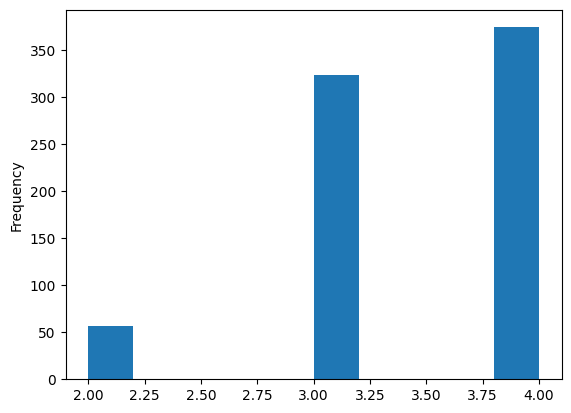

In [54]:
display(df["num_result"].plot(kind="hist"))


<Axes: ylabel='Frequency'>

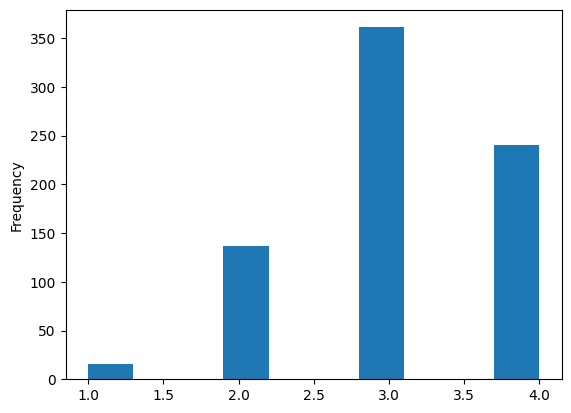

In [55]:
display(df["num_test"].plot(kind="hist"))

In [57]:
from scipy import stats

corr1 = stats.pearsonr(df["num_test"], df["num_result"])
display(corr1)

(0.509326815267549, 5.193873470807909e-51)

In [41]:
res

['Comprehensible',
 'Comprehensible',
 'Perfect',
 'Perfect',
 'Somewhat Comprehensible',
 'Perfect',
 'Perfect',
 'Comprehensible',
 'Perfect',
 'Perfect',
 'Perfect',
 'Perfect',
 'Comprehensible',
 'Perfect',
 'Comprehensible',
 'Perfect',
 'Comprehensible',
 'Perfect',
 'Perfect',
 'Comprehensible',
 'Somewhat Comprehensible',
 'Comprehensible',
 'Perfect',
 'Comprehensible',
 'Perfect',
 'Perfect',
 'Comprehensible',
 'Perfect',
 'Perfect',
 'Perfect',
 'Comprehensible',
 'Perfect',
 'Comprehensible',
 'Perfect',
 'Perfect',
 'Somewhat Comprehensible',
 'Perfect',
 'Comprehensible',
 'Perfect',
 'Perfect',
 'Comprehensible',
 'Perfect',
 'Comprehensible',
 'Perfect',
 'Perfect',
 'Comprehensible',
 'Somewhat Comprehensible',
 'Somewhat Comprehensible',
 'Comprehensible',
 'Comprehensible',
 'Perfect',
 'Perfect',
 'Somewhat Comprehensible',
 'Comprehensible',
 'Perfect',
 'Somewhat Comprehensible',
 'Comprehensible',
 'Perfect',
 'Comprehensible',
 'Perfect',
 'Comprehensible',
 '

In [38]:
datasets["test"]["label"]

['Somewhat Comprehensible',
 'Incomprehensible',
 'Comprehensible',
 'Perfect',
 'Somewhat Comprehensible',
 'Perfect',
 'Somewhat Comprehensible',
 'Comprehensible',
 'Perfect',
 'Comprehensible',
 'Comprehensible',
 'Comprehensible',
 'Comprehensible',
 'Perfect',
 'Comprehensible',
 'Comprehensible',
 'Comprehensible',
 'Somewhat Comprehensible',
 'Somewhat Comprehensible',
 'Somewhat Comprehensible',
 'Incomprehensible',
 'Comprehensible',
 'Perfect',
 'Somewhat Comprehensible',
 'Perfect',
 'Perfect',
 'Somewhat Comprehensible',
 'Comprehensible',
 'Perfect',
 'Comprehensible',
 'Comprehensible',
 'Comprehensible',
 'Comprehensible',
 'Somewhat Comprehensible',
 'Comprehensible',
 'Somewhat Comprehensible',
 'Perfect',
 'Somewhat Comprehensible',
 'Perfect',
 'Perfect',
 'Comprehensible',
 'Perfect',
 'Incomprehensible',
 'Perfect',
 'Comprehensible',
 'Somewhat Comprehensible',
 'Somewhat Comprehensible',
 'Comprehensible',
 'Somewhat Comprehensible',
 'Somewhat Comprehensible',


### coedit_gug_instr

In [8]:
from transformers import pipeline
pipe = pipeline("text2text-generation", model="/home/mlynatom/models/coedit_gug_instr/", tokenizer="grammarly/coedit-large", framework="pt", device=0, batch_size = 128)

In [9]:
res = pipe([TASK_PREFIX + x for x in datasets["test"]["sentence"]])
res = [x["generated_text"] for x in res]

/home/mlynatom/venvs/py3.10.4/lib/python3.10/site-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [10]:
df = pd.DataFrame(list(zip(res, datasets["test"]["label"])), columns=["result", "test"])
rename_dict = {
    "Incomprehensible": 1,
    "Somewhat Comprehensible": 2,
    "Comprehensible": 3,
    "Perfect": 4,
}

df["num_result"] = df.result.apply(lambda x: rename_dict[x])
df["num_test"] = df.test.apply(lambda x: rename_dict[x])

display(df)

,result,test,num_result,num_test
0,Comprehensible,Somewhat Comprehensible,3,2
1,Comprehensible,Incomprehensible,3,1
2,Perfect,Comprehensible,4,3
3,Perfect,Perfect,4,4
4,Somewhat Comprehensible,Somewhat Comprehensible,2,2
...,...,...,...,...
749,Comprehensible,Comprehensible,3,3
750,Perfect,Perfect,4,4
751,Comprehensible,Comprehensible,3,3
752,Somewhat Comprehensible,Comprehensible,2,3


In [13]:
acc = np.sum(df["num_result"]==df["num_test"])/len(df["num_test"])
display(acc)

0.5305039787798409

<Axes: ylabel='Frequency'>

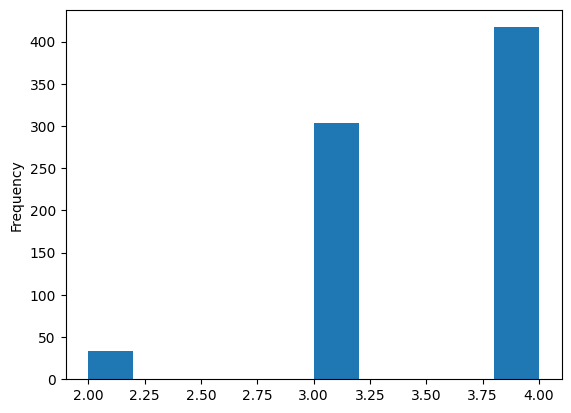

In [15]:
display(df["num_result"].plot(kind="hist"))

<Axes: ylabel='Frequency'>

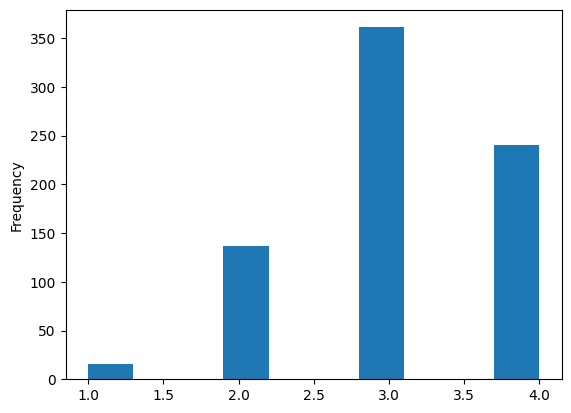

In [16]:
display(df["num_test"].plot(kind="hist"))

In [17]:
from scipy import stats

corr1 = stats.pearsonr(df["num_test"], df["num_result"])
display(corr1)

(0.5500253612109544, 7.72819968478461e-61)

### codedit gug fce instr L

In [41]:
from transformers import pipeline
pipe = pipeline("text2text-generation", model="/home/mlynatom/models/coedit_L_gug_fce_instr", tokenizer="grammarly/coedit-large", framework="pt", device=0, batch_size = 128)

In [42]:
res = pipe([TASK_PREFIX_GUG + x for x in datasets_gug["test"]["sentence"]])
res = [x["generated_text"] for x in res]

/home/mlynatom/venvs/py3.10.4/lib/python3.10/site-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [43]:
df = pd.DataFrame(list(zip(res, datasets["test"]["label"])), columns=["result", "test"])
rename_dict = {
    "Incomprehensible": 1,
    "Somewhat Comprehensible": 2,
    "Comprehensible": 3,
    "Perfect": 4,
}

df["num_result"] = df.result.apply(lambda x: rename_dict[x])
df["num_test"] = df.test.apply(lambda x: rename_dict[x])

display(df)

,result,test,num_result,num_test
0,Comprehensible,Somewhat Comprehensible,3,2
1,Comprehensible,Incomprehensible,3,1
2,Perfect,Comprehensible,4,3
3,Perfect,Perfect,4,4
4,Somewhat Comprehensible,Somewhat Comprehensible,2,2
...,...,...,...,...
749,Comprehensible,Comprehensible,3,3
750,Perfect,Perfect,4,4
751,Comprehensible,Comprehensible,3,3
752,Comprehensible,Comprehensible,3,3


In [44]:
acc = np.sum(df["num_result"]==df["num_test"])/len(df["num_test"])
display(acc)

0.5755968169761273

### coedit gug instr xl

In [ ]:
from transformers import pipeline
pipe = pipeline("text2text-generation", model="/home/mlynatom/models/coedit_xl_gug_instr", tokenizer="grammarly/coedit-xl", framework="pt", device=0, batch_size = 128)

In [ ]:
res = pipe([TASK_PREFIX + x for x in datasets["test"]["sentence"]])
res = [x["generated_text"] for x in res]

In [ ]:
df = pd.DataFrame(list(zip(res, datasets["test"]["label"])), columns=["result", "test"])
rename_dict = {
    "Incomprehensible": 1,
    "Somewhat Comprehensible": 2,
    "Comprehensible": 3,
    "Perfect": 4,
}

df["num_result"] = df.result.apply(lambda x: rename_dict[x])
df["num_test"] = df.test.apply(lambda x: rename_dict[x])

display(df)

In [ ]:
display(df["num_result"].plot(kind="hist"))

In [ ]:
display(df["num_test"].plot(kind="hist"))

In [ ]:
from scipy import stats

corr1 = stats.pearsonr(df["num_test"], df["num_result"])
display(corr1)